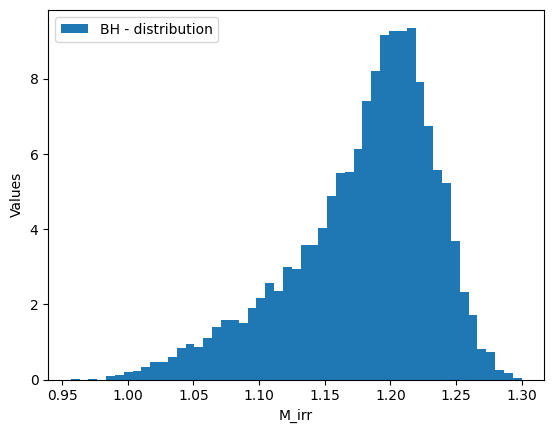

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astroML import stats as astroMLstats

N = 10000

sigma = 0.02
mu = 1
M = np.random.normal(mu, sigma, N)
chi = np.random.uniform(0,1,N)

M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2) #per definizione

sigmaG2 = astroMLstats.sigmaG(M_irr) # quantile al 75 - quantile al 25
binsize = 2.7 * sigmaG2 / (N**(1/3)) #formula di Freedman-Diaconis
binsG = np.append( np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsize) , M_irr.max()) 

plt.hist(M_irr, 51, density=True, label = "BH - distribution")
plt.xlabel("M_irr")
plt.ylabel("Values")
plt.legend()
plt.show()

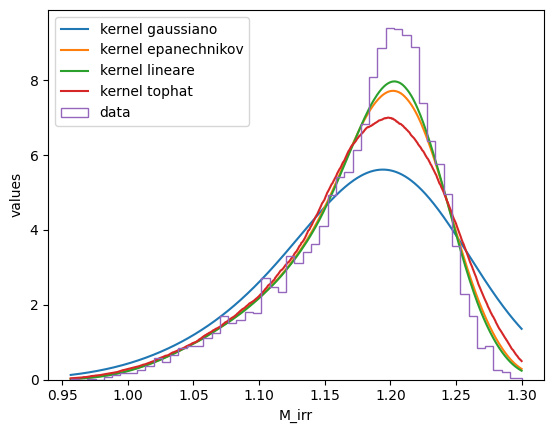

In [3]:
from sklearn.neighbors import KernelDensity

xgrid = np.linspace(M_irr.min(),M_irr.max(),1000)  

def kde (data, bandwidth, kernel):
    KDE = KernelDensity(bandwidth = bandwidth, kernel = kernel)
    KDE.fit(data[:, np.newaxis]) 
    log_pdf = KDE.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)


bandwidth = 0.05

pdf = kde (M_irr, bandwidth, kernel = "gaussian")       # funzione di densità della distribuzione normale
pdf2 = kde (M_irr, bandwidth, kernel = "epanechnikov")  # parabolico e ha un supporto finito, stima più localizzata rispetto al gaussiano
pdf3 = kde (M_irr, bandwidth, kernel = "linear")        # assegna pesi decrescenti linearmente alla distanza dal punto di riferimento. densità meno liscia rispetto al gaussiano
pdf4 = kde (M_irr, bandwidth, kernel = "tophat")        # kernel uniforme, che assegna lo stesso peso a tutti i punti entro una certa finestra e zero al di fuori. meno utilizzato perché può generare stime meno precise

plt.plot(xgrid,pdf, label = "kernel gaussiano")
plt.plot(xgrid,pdf2, label = "kernel epanechnikov")
plt.plot(xgrid,pdf3, label = "kernel lineare")
plt.plot(xgrid,pdf4, label = "kernel tophat")

plt.hist(M_irr, binsG, label = "data", density= True, histtype="step")
plt.xlabel("M_irr")
plt.ylabel("values")
plt.legend()
plt.show()


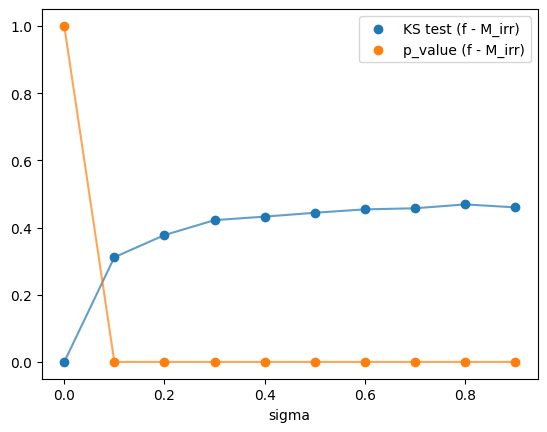

In [20]:
import scipy as sp

statistic = []
p_value = []
x = []

for i in range(10) :

    sigma =  i/10

    chi_1 = np.random.uniform(0,1,N)
    M = np.random.normal(mu, sigma, N)

    M_irr = M * np.sqrt(( 1+ np.sqrt(1-chi**2))/2)
    f = np.sqrt(( 1+ np.sqrt(1-chi**2))/2)

    statistic_i , p_value_i = sp.stats.ks_2samp(f , M_irr)

    #kstest: Esegue il test KS su un campione rispetto a una distribuzione.
    #ks_2samp: Confronta due campioni indipendenti.

    statistic.append(statistic_i)
    p_value.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (f - M_irr)")
plt.plot(x, statistic, linestyle="-", alpha=0.7)

plt.scatter(x, p_value, label = "p_value (f - M_irr)")
plt.plot(x, p_value, linestyle="-", alpha=0.7)

plt.xlabel("sigma")

plt.legend()
plt.show()


Il test KS nasce per vedere quanto vale il massimo della differenza tra due funzioni.
Come si vede dal grafico sopra, nel limite di $\sigma = 0$ (cioè una Dirac-delta), $M$ è una costante pari a $\mu$, il KS test restituisce il valore di 0, con un p-value di 1. Questo ad indicare che le due funzioni sono propriamente le stesse. <br>
Al crescere di $\sigma$ invece giungiamo rapidamente ad una saturazione, con il valore del p-value che crolla circa a 0. Questa crescita della statistica KS segnala una differenza crescente tra le due distribuzioni. <br>
Quando $\sigma$ diventa maggiore di 0.3, la statistica KS si stabilizza attorno a 0.4 / 0.45, suggerendo che la differenza tra le distribuzioni non aumenta più in modo significativo. <br>
Il motivo di questo comportamento è da cercarsi nella definizione di $f$, che non dipende in alcun modo da $\sigma$, mentre $M_{\text{irr}}$ ne subisce l'influenza essendo $M$ distribuita gaussianamente, proprio con larghezza $\sigma$. <br>
Dopo 0.3 la dispersione di $M$ è abbastanza grande da rendere le due distribuzioni diverse in modo significativo. Tuttavia, la differenza tra le distribuzioni raggiunge un limite perché il rapporto $f$ rimane sempre limitato nella stessa gamma di valori compresi tra 1 e 0.7 (si può vedere dal plot sotto).

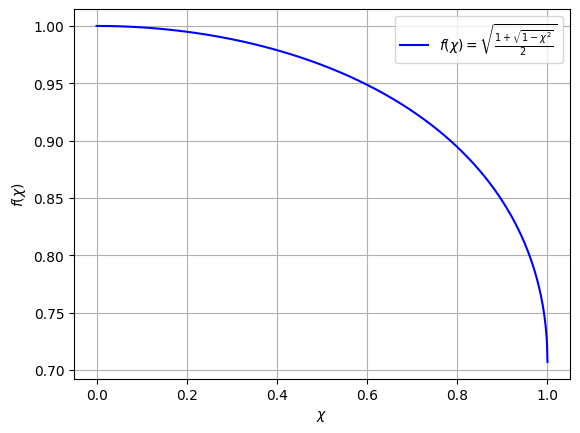

In [21]:
def f(chi):
    return np.sqrt((1 + np.sqrt(1 - chi**2)) / 2)

chi_values = np.linspace(0, 1, 1000)
f_values = f(chi_values)

plt.plot(chi_values, f_values, label=r'$f(\chi) = \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$', color="blue")
plt.xlabel(r'$\chi$')
plt.ylabel(r'$f(\chi)$')
plt.grid(True)
plt.legend()
plt.show()

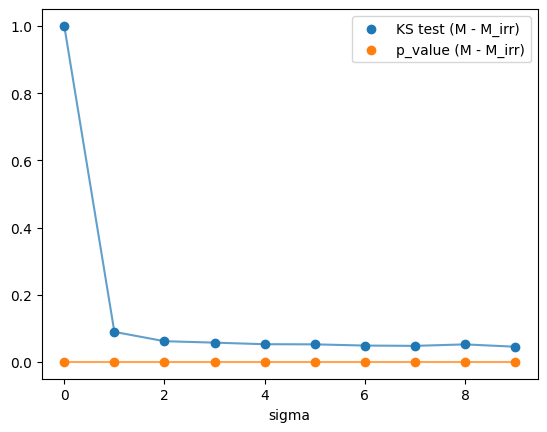

In [ ]:
statistic = []
p_value_2 = []
x = []

for i in range(10) :

    sigma =  i
    chi = np.random.uniform(0,1,N)
    M = np.random.normal(mu, sigma, N)
    M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2)

    statistic_i , p_value_i = sp.stats.ks_2samp(M , M_irr)

    statistic.append(statistic_i)
    p_value_2.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (M - M_irr)")
plt.plot(x, statistic, linestyle="-", alpha=0.7)

plt.scatter(x, p_value_2, label = "p_value (M - M_irr)")
plt.plot(x, p_value_2, linestyle="-", alpha=0.7)

plt.xlabel("sigma")

plt.legend()
print(p_value_2)
plt.show()

Nel primo test abbiamo confrontato la distribuzione del rapporto con quella di M_irr. <br>
Nel secondo test è stato confrontato direttamente con M. <br>
Questa trasformazione introduce una moltiplicazione punto per punto su M che dipende da $\chi$, e quindi modifica la forma della distribuzione.

Per piccoli valori di $\sigma$, M è molto concentrato attorno a $\mu$ e la trasformazione introduce una distorsione significativa, rendendo la distribuzione molto diversa da quella di M. la statistica KS risulta elevata e il p_value basso.

Per grandi valori di $\sigma$ invece, M è molto disperso, la moltiplicazione punto per punto con il fattore "f"  ha un effetto relativo minore, e
le due distribuzioni tendono a somigliarsi, con una statistica KS che decresce.

Per quanto riguarda il p_value, nel test KS indica quanto è probabile ottenere una distanza tra le distribuzioni almeno grande quanto quella osservata, se le due distribuzioni fossero in realtà uguali. Quando N è grande (nel nostro caso 10000), anche una piccola distanza tra le distribuzioni produce una statistica KS che può essere piccola in valore assoluto, ma per il test del p_value si giunge egualmente a zero numerico.


# Calcolo della CDF
Dobbiamo calcolare la funzione di distribuzione cumulativa (CDF) della funzione:

$$
f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}, \quad 0 \leq x \leq 1
$$

La CDF è definita come:


$$
F(x') = \int_0^{x'} f(x) \, dx = \int_0^{x'} \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}} \, dx
$$


---

**1. Cambio di variabile**  
Poniamo:

$$
u = f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}
$$

Deriviamo rispetto a \( x \):

$$
du = \frac{1}{2} \cdot \frac{1}{\sqrt{2(1+\sqrt{1-x^2})}} \cdot \frac{-x}{\sqrt{1-x^2}} \, dx
$$

Semplificando:

$$
du = \frac{-x}{2\sqrt{2(1+\sqrt{1-x^2})} \cdot \sqrt{1-x^2}} \, dx
$$

Risolvendo per \( dx \):

$$
dx = \frac{-2\sqrt{2(1+\sqrt{1-x^2})} \cdot \sqrt{1-x^2}}{x} \, du
$$

---

**2. Sostituzione nell'integrale**  
Dopo aver sostituito i termini e semplificato l'integrale, otteniamo il risultato finale:

$$
F(x) = 2 \cdot \frac{2f^2 - 1}{\sqrt{1 - f^2}}
$$

Dove \( f(x) \) è:

$$
f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}
$$

---

**Conclusione**  
Abbiamo calcolato analiticamente la CDF della funzione data. Il risultato finale è:

$$
F(x) = 2 \cdot \frac{2f^2 - 1}{\sqrt{1 - f^2}}
$$



